In [1]:
import os
import glob
import cv2
import imageio

import numpy as np 
import pandas as pd 
import nibabel as nib
import matplotlib.pyplot as plt
from ipywidgets import *
from PIL import Image
from matplotlib.pyplot import figure

In [2]:
file_list = []
for dirname, _, filenames in os.walk('./dataset'):
    for filename in filenames:
        file_list.append((dirname, filename))

df_files = pd.DataFrame(file_list, columns =['dirname', 'filename']) 
df_files.sort_values(by=['filename'], ascending=True)

,dirname,filename
0,./dataset\segmentations,segmentation-0.nii
1,./dataset\segmentations,segmentation-1.nii
2,./dataset\segmentations,segmentation-10.nii
3,./dataset\segmentations,segmentation-100.nii
4,./dataset\segmentations,segmentation-101.nii
...,...,...
227,./dataset\volume_pt6,volume-95.nii
228,./dataset\volume_pt6,volume-96.nii
229,./dataset\volume_pt6,volume-97.nii
230,./dataset\volume_pt6,volume-98.nii


In [3]:
df_files["mask_dirname"]  = ""
df_files["mask_filename"] = ""

for i in range(131):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"
    
    df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = "./dataset/segmentations"

# drop segment rows
df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True) 

df_files

,dirname,filename,mask_dirname,mask_filename
0,./dataset\volume_pt1,volume-0.nii,./dataset/segmentations,segmentation-0.nii
1,./dataset\volume_pt1,volume-1.nii,./dataset/segmentations,segmentation-1.nii
2,./dataset\volume_pt1,volume-10.nii,./dataset/segmentations,segmentation-10.nii
3,./dataset\volume_pt6,volume-100.nii,./dataset/segmentations,segmentation-100.nii
4,./dataset\volume_pt8,volume-101.nii,./dataset/segmentations,segmentation-101.nii
...,...,...,...,...
126,./dataset\volume_pt6,volume-95.nii,./dataset/segmentations,segmentation-95.nii
127,./dataset\volume_pt6,volume-96.nii,./dataset/segmentations,segmentation-96.nii
128,./dataset\volume_pt6,volume-97.nii,./dataset/segmentations,segmentation-97.nii
129,./dataset\volume_pt6,volume-98.nii,./dataset/segmentations,segmentation-98.nii


In [4]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [5]:
sample = 0
sample_ct = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
sample_mask = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])

print(f'CT Shape:   {sample_ct.shape}\nMask Shape: {sample_mask.shape}')

CT Shape:   (512, 512, 75)
Mask Shape: (512, 512, 75)


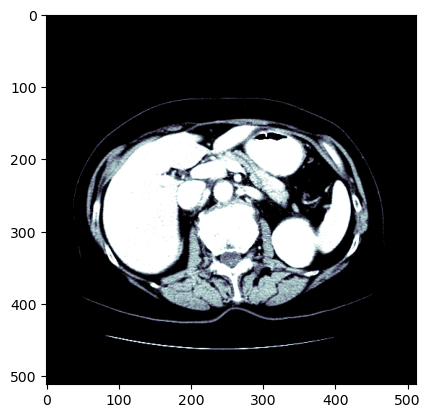

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Your defined DICOM windows
dicom_windows = {
    'liver': (150, 30)
}


def window_image_np(array, w, l):
    img_min = l - w // 2
    img_max = l + w // 2
    windowed_array = np.clip(array, img_min, img_max)
    return (windowed_array - img_min) / (img_max - img_min)

# Assuming 'sample_ct' is a NumPy array you have previously loaded
sample_ct_np = sample_ct.astype(np.float32)

# Apply the windowing function to the selected slice
windowed_ct_np = window_image_np(sample_ct_np[..., 55], *dicom_windows['liver'])

# Display the windowed image
plt.imshow(windowed_ct_np, cmap=plt.cm.bone)
plt.show()

In [3]:
import os
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

class LiverTumorSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mask_transform=None, min_white_pixels=10):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.images = []
        self.masks = []

        all_image_names = os.listdir(image_dir)
        for img_name in all_image_names:
            img_path = os.path.join(self.image_dir, img_name)
            mask_path = os.path.join(self.mask_dir, img_name)

            mask = Image.open(mask_path).convert('L')
            mask_np = np.array(mask)
            
            # Check if the mask has at least min_white_pixels white pixels
            if np.sum(mask_np > 0) >= min_white_pixels:
                self.images.append(img_name)  # add the image name
                self.masks.append(img_name)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        image = Image.open(img_path).convert('L')
        mask = Image.open(mask_path).convert('L')

        if self.transform:
            image = self.transform(image)

        if self.mask_transform:
            mask = self.mask_transform(mask)

        mask = (np.array(mask) > 0).astype(np.float32)
        mask = torch.from_numpy(mask)

        return image, mask

mean = [0.485]
std = [0.229]

transform = Compose([
    Resize((256, 256)),
    ToTensor(),
    Normalize(mean, std)
])
mask_transform = Compose([
    Resize((256, 256)),
    ToTensor()
])

# Instantiate the dataset with the transformations
dataset = LiverTumorSegmentationDataset(
    image_dir='train_tumor_images',
    mask_dir='train_tumor_masks',
    transform=transform,
    mask_transform=mask_transform
)

# Split the dataset
train_size = int(0.7 * len(dataset))
valid_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])

# Create dataloaders
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [2]:
def calculate_f1_score(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    
    tp = np.sum(y_true * y_pred)
    fp = np.sum((1 - y_true) * y_pred)
    fn = np.sum(y_true * (1 - y_pred))
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return f1

In [3]:
import torch
import numpy as np
from unet_model import UNet

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(n_channels=1, n_classes=1)
model.load_state_dict(torch.load(r"C:\Users\syed_fahim_ahmed\Desktop\Coding_With_Fahim\Deep_Learning\Project\Code\tumor_result\unet_liver_tumor_segmentation_best.pth"))
model.eval()


model = model.to(device)


true_labels = []
predicted_labels = []


with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        

        preds = torch.sigmoid(outputs) > 0.5
        
        true_labels.append(masks.cpu().numpy())
        predicted_labels.append(preds.cpu().numpy())

# Flatten the lists and compute the F1 score
true_labels = np.vstack(true_labels).flatten()
predicted_labels = np.vstack(predicted_labels).flatten()
test_f1_score = calculate_f1_score(true_labels, predicted_labels)

print(f'F1 Score on the test set: {test_f1_score}')

F1 Score on the test set: 0.7720384417093065


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi
    
class conv_block(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )


    def forward(self,x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x

class AttU_Net(nn.Module):
    def __init__(self,img_ch=1,output_ch=1):
        super(AttU_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=64)
        self.Conv2 = conv_block(ch_in=64,ch_out=128)
        self.Conv3 = conv_block(ch_in=128,ch_out=256)
        self.Conv4 = conv_block(ch_in=256,ch_out=512)
        self.Conv5 = conv_block(ch_in=512,ch_out=1024)

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Att5 = Attention_block(F_g=512,F_l=512,F_int=256)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Att4 = Attention_block(F_g=256,F_l=256,F_int=128)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Att3 = Attention_block(F_g=128,F_l=128,F_int=64)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Att2 = Attention_block(F_g=64,F_l=64,F_int=32)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        x4 = self.Att5(g=d5,x=x4)
        d5 = torch.cat((x4,d5),dim=1)        
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4,x=x3)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3,x=x2)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2,x=x1)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return d1

In [6]:
import torch
import numpy as np
from unet_model import UNet


# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AttU_Net(img_ch=1,output_ch=1)
model.load_state_dict(torch.load(r"C:\Users\syed_fahim_ahmed\Desktop\Coding_With_Fahim\Deep_Learning\Project\Code\tumor_result_attention\atten_unet_liver_tumor_segmentation_best.pth"))


model = model.to(device)


true_labels = []
predicted_labels = []


with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        

        preds = torch.sigmoid(outputs) > 0.5
        
        true_labels.append(masks.cpu().numpy())
        predicted_labels.append(preds.cpu().numpy())

# Flatten the lists and compute the F1 score
true_labels = np.vstack(true_labels).flatten()
predicted_labels = np.vstack(predicted_labels).flatten()
test_f1_score = calculate_f1_score(true_labels, predicted_labels)

print(f'F1 Score on the test set: {test_f1_score}')

F1 Score on the test set: 0.7882642958685261


In [11]:
import os
import glob
import cv2
import pandas as pd
import matplotlib.pyplot as plt
# Assuming the provided paths are correct, we will replace them with the uploaded file's path.
# Replace with the actual path if different
unet_performance_path = r"C:\Users\syed_fahim_ahmed\Desktop\Coding_With_Fahim\Deep_Learning\Project\Code\tumor_result\performance.txt"

attention_unet_performance_path = r"C:\Users\syed_fahim_ahmed\Desktop\Coding_With_Fahim\Deep_Learning\Project\Code\tumor_result_attention\performance.txt"



unet_performance_df = pd.read_csv(unet_performance_path, header=None, names=['Epoch', 'F1Score'])
attention_unet_performance_df = pd.read_csv(attention_unet_performance_path, header=None, names=['Epoch', 'F1Score'])

# Plot the F1 Score for both UNet and Attention UNet
plt.figure(figsize=(10, 5))
plt.plot(unet_performance_df['Epoch'], unet_performance_df['F1Score'], label='UNet Validation F1 Score', color='blue')
plt.plot(attention_unet_performance_df['Epoch'], attention_unet_performance_df['F1Score'], label='Attention UNet Validation F1 Score', color='orange')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Validation F1 Score Over Epochs')
plt.legend()
plt.grid(True)

# Save the plot to the results directory
plt.savefig('f1_score_comparison.png')
plt.close()  # Close the plot to avoid displaying it in the notebook output

# Output the path to the saved plot
print(f"Plot saved to f1_score_comparison.png")

Plot saved to f1_score_comparison.png


In [1]:
from matplotlib import cm
import torch
import numpy as np
from unet_model import UNet
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AttU_Net(img_ch=1,output_ch=1)
model.load_state_dict(torch.load(r"C:\Users\syed_fahim_ahmed\Desktop\Coding_With_Fahim\Deep_Learning\Project\Code\tumor_result_attention\atten_unet_liver_tumor_segmentation_best.pth"))
model.eval()

results_dir = './tumor_result_attention'
model = model.to(device)

def overlay_mask(img, mask, color='red', alpha=0.5):
    """ Overlay mask on the image. """
    # Create an RGB version of the grayscale image
    img_rgb = cm.gray(img)[:,:,:3]
    mask_idx = np.where(mask == 1)
    img_rgb[mask_idx[0], mask_idx[1], :] = np.array(cm.colors.to_rgb(color))
    combined = (img_rgb * alpha + img_rgb * (1 - alpha)).clip(0, 1)
    return combined

# Visualize one example with overlay
image, mask = next(iter(test_loader))
image = image.to(device)
mask = mask.to(device)
output = model(image)

# Apply sigmoid to output to get the probability map
output_prob = torch.sigmoid(output)

# Apply threshold to turn it into a binary mask
threshold = 0.5
output_bin = (output_prob > threshold).float()

# Convert to numpy arrays for visualization
image_np = image[0].squeeze().cpu().numpy()
mask_np = mask[0].squeeze().cpu().numpy()
output_np = output_bin[0].squeeze().cpu().detach().numpy()

# Overlay the masks on the image
overlay_true = overlay_mask(image_np, mask_np)
overlay_pred = overlay_mask(image_np, output_np)

plt.figure(figsize=(20, 5))
plt.suptitle('Liver Tumor Seg Data - Model: Attention Unet', fontsize=16)

plt.subplot(1, 5, 1)
plt.imshow(image_np, cmap='bone')
plt.title('Image')

plt.subplot(1, 5, 2)
plt.imshow(mask_np, cmap='bone')
plt.title('True Mask')

plt.subplot(1, 5, 3)
plt.imshow(output_np, cmap='bone')
plt.title('Predicted Mask (Thresholded)')

plt.subplot(1, 5, 4)
plt.imshow(overlay_true)
plt.title('Image with True Mask Overlay')

plt.subplot(1, 5, 5)
plt.imshow(overlay_pred)
plt.title('Image with Predicted Mask Overlay')

plt.savefig(os.path.join(results_dir, 'test1.png'))
plt.show()


NameError: name 'AttU_Net' is not defined

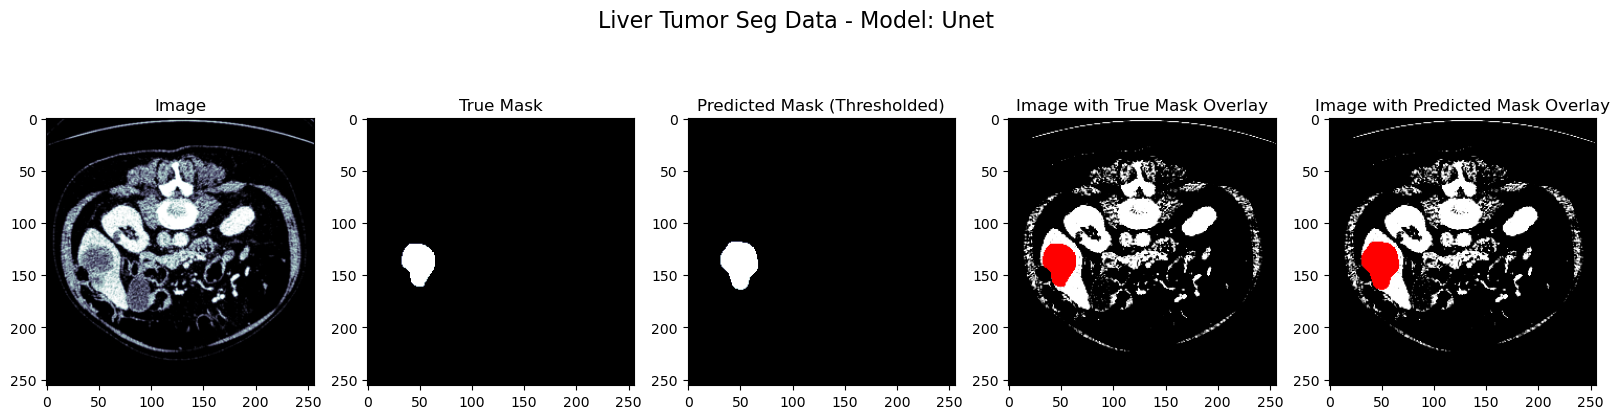

In [12]:
from matplotlib import cm
import torch
import numpy as np
from unet_model import UNet
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_channels=1, n_classes=1)
model.load_state_dict(torch.load(r"C:\Users\syed_fahim_ahmed\Desktop\Coding_With_Fahim\Deep_Learning\Project\Code\tumor_result\unet_liver_tumor_segmentation_best.pth"))
model.eval()

results_dir = './tumor_result'
model = model.to(device)

def overlay_mask(img, mask, color='red', alpha=0.5):
    """ Overlay mask on the image. """
    # Create an RGB version of the grayscale image
    img_rgb = cm.gray(img)[:,:,:3]
    mask_idx = np.where(mask == 1)
    img_rgb[mask_idx[0], mask_idx[1], :] = np.array(cm.colors.to_rgb(color))
    combined = (img_rgb * alpha + img_rgb * (1 - alpha)).clip(0, 1)
    return combined

# Visualize one example with overlay
image, mask = next(iter(test_loader))
image = image.to(device)
mask = mask.to(device)
output = model(image)

# Apply sigmoid to output to get the probability map
output_prob = torch.sigmoid(output)

# Apply threshold to turn it into a binary mask
threshold = 0.5
output_bin = (output_prob > threshold).float()

# Convert to numpy arrays for visualization
image_np = image[0].squeeze().cpu().numpy()
mask_np = mask[0].squeeze().cpu().numpy()
output_np = output_bin[0].squeeze().cpu().detach().numpy()

# Overlay the masks on the image
overlay_true = overlay_mask(image_np, mask_np)
overlay_pred = overlay_mask(image_np, output_np)

plt.figure(figsize=(20, 5))
plt.suptitle('Liver Tumor Seg Data - Model: Unet', fontsize=16)

plt.subplot(1, 5, 1)
plt.imshow(image_np, cmap='bone')
plt.title('Image')

plt.subplot(1, 5, 2)
plt.imshow(mask_np, cmap='bone')
plt.title('True Mask')

plt.subplot(1, 5, 3)
plt.imshow(output_np, cmap='bone')
plt.title('Predicted Mask (Thresholded)')

plt.subplot(1, 5, 4)
plt.imshow(overlay_true)
plt.title('Image with True Mask Overlay')

plt.subplot(1, 5, 5)
plt.imshow(overlay_pred)
plt.title('Image with Predicted Mask Overlay')

plt.savefig(os.path.join(results_dir, 'test.png'))
plt.show()